In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import os, sys
import matplotlib.pyplot as plt
import librosa
from librosa import display
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
os.chdir('/content/drive/MyDrive/Audio_controlled_drone/wavdata')

In [3]:
hover = []
land = []
mback = []
mfor = []
mleft = []
mright = []
takeoff = []

hover = os.listdir('hover')
land = os.listdir('land')
mback = os.listdir('mback')
mfor = os.listdir('mfor')
mleft = os.listdir('mleft')
mright = os.listdir('mright')
takeoff = os.listdir('takeoff')

names_list  = ['hover', 'land', 'mback', 'mfor', 'takeoff', 'mleft', 'mright']
list = [hover, land, mback, mfor, takeoff, mleft, mright]

In [4]:
!dir

FTimages  land	    mback      mfor	     mleft   takeoff
hover	  land.ogg  MELimages  Mforward.ogg  mright


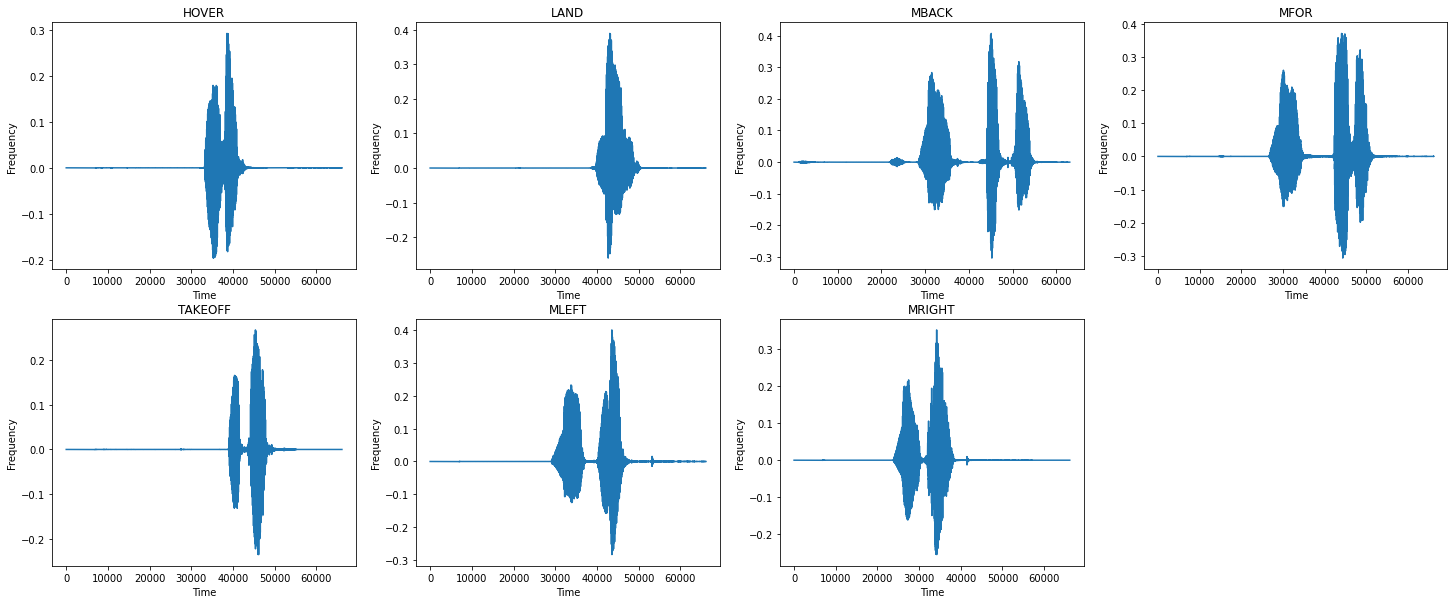

In [5]:
fig = plt.figure(figsize=(25, 10))
rows = 2
columns = 4
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'1.wav', duration=3) 
    plt.plot(audio)
    plt.axis('on')
    plt.title(names_list[r].upper())
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    r+=1

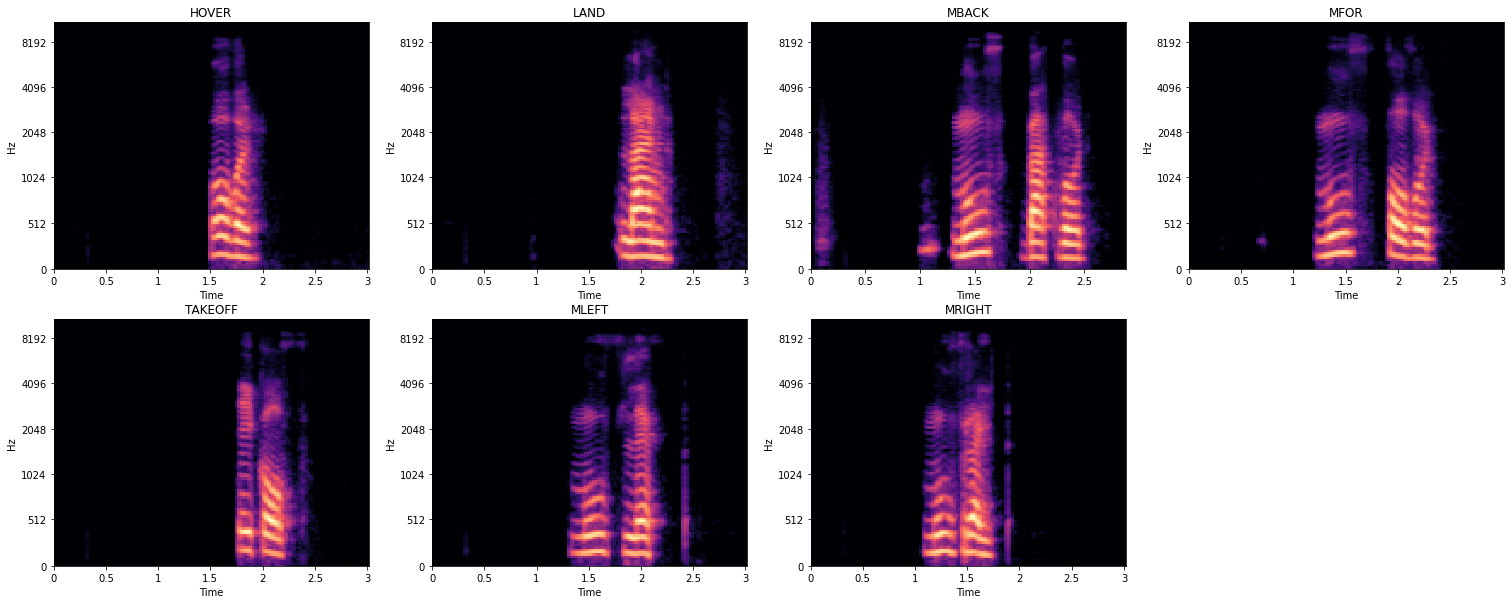

In [6]:
fig = plt.figure(figsize=(26, 10))
rows = 2
columns = 4
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'1.wav', duration=3) 
    mels = librosa.feature.melspectrogram(y=audio,sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(mels,ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title(names_list[r].upper())
    r+=1

In [7]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate) #can change number of features
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [8]:
extracted_features = []
r=0
for i in list:
    for j in i:
        data=features_extractor(names_list[r]+'/'+j)
        extracted_features.append([data,r])
    r+=1

In [9]:
df=pd.DataFrame(extracted_features,columns=['feature','class'])

In [10]:
df

,feature,class
0,"[-301.46558, 133.55794, 9.937642, 12.280746, -...",0
1,"[-390.97107, 121.301476, -25.223553, 7.9647803...",0
2,"[-528.10724, 76.55931, 6.4072266, 5.920804, -1...",0
3,"[-440.81723, 130.79251, -20.845499, 4.0018907,...",0
4,"[-339.73822, 133.65117, -20.911839, 11.907706,...",0
...,...,...
699,"[-357.49786, 103.36262, -6.8585606, 15.650823,...",6
700,"[-486.96982, 109.66109, 16.955788, 14.556486, ...",6
701,"[-528.27606, 107.66405, -31.501175, 11.8297825...",6
702,"[-620.1334, 88.63358, 27.416939, 17.818327, -2...",6


In [11]:
X=np.array(df['feature'].tolist())
y=np.array(df['class'].tolist())

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)

In [12]:
X.shape

(704, 20)

In [13]:
model=Sequential()
###first layer
model.add(Dense(256,input_shape=(20,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(7, 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0

In [15]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model_save_filename = "model.h5"
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy",mode='max', save_best_only=True)
history = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_test, y_test),callbacks=[mdlcheckpoint_cb],verbose=1)
#plot history
#take model that has val acc max;

Epoch 1/1000
36/36 [==============================] - 2s 17ms/step - loss: 1.5248 - accuracy: 0.4698 - val_loss: 1.6807 - val_accuracy: 0.4539
Epoch 2/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.5853 - accuracy: 0.4061 - val_loss: 1.6695 - val_accuracy: 0.4184
Epoch 3/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.5146 - accuracy: 0.4914 - val_loss: 1.6149 - val_accuracy: 0.4397
Epoch 4/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.5254 - accuracy: 0.4688 - val_loss: 1.6476 - val_accuracy: 0.4326
Epoch 5/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.5097 - accuracy: 0.4472 - val_loss: 1.6676 - val_accuracy: 0.4184
Epoch 6/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.4909 - accuracy: 0.4667 - val_loss: 1.6512 - val_accuracy: 0.4184
Epoch 7/1000
36/36 [==============================] - 0s 5ms/step - loss: 1.5886 - accuracy: 0.4597 - val_loss: 1.6478 - val_accuracy: 0.4681
Epoch

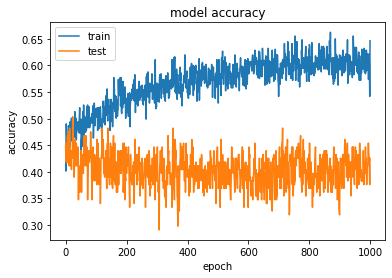

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
#model = keras.models.load_model('model.h5')
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.42553192377090454
